# Cyberbullying Classification

### 1. The degree of aggressivity & Negativity

### 2. Personnalization
    - Depency tree, establish the subject, object, complement, aux
    - Also, tell the (person 1st, 2nd, 3rd) of the subject and the object. 
    - Identify what are they accuse from 
    - Identify who’s being targeted (Lexicon or wordnet)
    - Established if the aux is directed to the object  (Establishing intention)
### 3. Harms inflicted and to who
    - Now, using the complement (output of dependency tree), we can map these to threats
    - We need wordnet to identify threat. (Actually better lexicon than word net)
    - To object refers to what category? race, nationality, religion, color, gender, 



Set your environment
- source spacy/bin/activate (Bash)
- get back to your base: deactivate (Bash)

You have to be in anaconda3 interpreter

# Import data

In [1]:
import numpy as np
import pandas as pd 
import os
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
import re
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from spacy import displacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import spacy
import nltk
nlp = spacy.load("en_core_web_sm")
import en_core_web_sm
nlp = en_core_web_sm.load()


In [2]:
macbook = ('/Users/philippebeliveau/Desktop/Notebook/Winter_2024/Text_mining/Git_MiningRepository/Text_miningProject/Notebook/cyberbullying_tweets.csv')

mac_mini = ('/Users/philippebeliveau/Desktop/Notebook_Jupyter_R/Winter_2024/Text_mining/Project/Text_miningProject/Notebook/cyberbullying_tweets.csv')

df = pd.read_csv(mac_mini)
df.head()
categories = df['cyberbullying_type'].unique()


In [3]:
# Initialize an empty dictionary to hold the tweets by category
tweets_by_category = {}

# Iterate over each category
for category in categories:
    # Filter the dataset for the current category
    category_tweets = df[df['cyberbullying_type'] == category]['tweet_text'].tolist()
    
    # Add the list of tweets to the dictionary
    tweets_by_category[category] = category_tweets

category = tweets_by_category['ethnicity'][100:120]

# Data preprocessing

In [13]:
# Filter 2000 tweets from each category
df = df.groupby('cyberbullying_type').apply(lambda x: x.sample(min(len(x), 100))).reset_index(drop=True)

# Now you can work with 'sampled_df' which contains 2000 samples from each category
df.shape[0]

600

In [14]:
import re

def clean_text(text):
    #removing hastags, links and specific symbol
    pattern=re.compile(r"(#[a-zA-Z0-9]+|@[a-zA-Z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @|Ã°ÂÂÂ)")
    text = pattern.sub('', text)
    text = " ".join(text.split())
    
    return text

In [15]:
#cleaning of data
df['clean_data']=df['tweet_text'].apply(lambda x: clean_text(x))

In [16]:
df.shape[0]

600

In [17]:
# Initialize an empty dictionary to hold the tweets by category
tweets_by_category = {}

# Iterate over each category
for category in categories:
    # Filter the dataset for the current category
    category_tweets = df[df['cyberbullying_type'] == category]['clean_data'].tolist()
    
    # Add the list of tweets to the dictionary
    tweets_by_category[category] = category_tweets

category = tweets_by_category['ethnicity'][100:120]

# Part 2 - Critique vs Insult

# Simple approach
- Extract the adjectives, nouns, the Subject Person, and the complement/conjunction. 
- Extract the name entities
- Extract all the synonyms of the adjective, nouns and complement into a long list.
- Create a polarity score using Vadersentiment on the tweet itself and on the list of synonyms

In [18]:
df_clean = df

### Version 

In [19]:
# Test with new elements
from nltk.sentiment.util import mark_negation
from nltk.corpus import sentiwordnet as swn

# Initialize lists to store data
analyzer = SentimentIntensityAnalyzer()
data = []

for tweet in df_clean['clean_data']:
    # Analyze the tweet
    doc = nlp(tweet)

    # Extract adjectives, nouns, subjects and complements/conjunctions/root
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    subjects = [(token.text, token.morph.get('Person')) for token in doc if token.dep_ == "nsubj"]
    complements = [token.text for token in doc if token.dep_ in ("acomp", "conj", "ROOT")]

    # Extract children of ccomp or conj
    ccomp_conj_children = []
    ccomp_conj_sentiments = []
    AUX_child = []
    for token in doc:
        if token.dep_ in ("acomp", "conj", 'ROOT', 'ccomp'):
            children = [child.text for child in token.children]
            ccomp_conj_children.append(children)
            # Compute sentiment scores for each child and append to list
            ccomp_conj_sentiments.extend([analyzer.polarity_scores(child)["compound"] for child in children])

        if token.pos_ in ("AUX", 'PROPN'): 
            child = [child.text for child in token.children]
            AUX_child.append(child)

        # if token.dep_ in ("acomp", 'advmod', 'amod',"appos", "coordination"): 
        #     child = token.text
        #     AUX_child.append(child)
    # Compute sum of sentiment scores for ccomp or conj children
    sum_ccomp_conj_sentiment = sum(ccomp_conj_sentiments)

    # Extract named entities and their types
    named_entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Extract synonyms
    synonyms = []
    for token in doc:
        if token.pos_ in ("ADJ", "NOUN", 'ccomp'):
            for syn in wordnet.synsets(token.text):
                for lemma in syn.lemmas():
                    synonyms.append(lemma.name())

    # Create a polarity score
    sentiment_score = analyzer.polarity_scores(tweet)["compound"]
    synonyms_sentiment_score = analyzer.polarity_scores(" ".join(synonyms))["compound"]

    # Check if "?" is in the tweet
    has_question_mark = "?" in tweet

    # Mark negation in the tweet
    negated_tweet = " ".join(mark_negation(tweet.split()))

    # Check for discourse markers
    discourse_markers = ['say', 'claim']
    has_discourse_marker = any(marker in tweet for marker in discourse_markers)

    # Check if there is a 3rd person verb in the tweet
    has_third_person_verb = any(token.morph.get('Person') == '3' and token.pos_ == 'VERB' for token in doc)

    # Get SentiWordNet polarity scores
    senti_scores = []
    for token in doc:
        synsets = list(swn.senti_synsets(token.text))
        if synsets:
            senti_scores.append(synsets[0].pos_score() - synsets[0].neg_score())

    avg_senti_score = sum(senti_scores) / len(senti_scores) if senti_scores else 0

    # Append data to list
    data.append({
        "Tweet": tweet,
        "Has Question Mark": has_question_mark,
        "Negated Tweet": negated_tweet,
        "Has Discourse Marker": has_discourse_marker,
        "Tweet": tweet,
        "Adjectives": adjectives,
        "Nouns": nouns,
        "Subjects": subjects,
        "Complements": complements,
        "Dependency Children": ccomp_conj_children,
        "Dependency Sentiment": sum_ccomp_conj_sentiment,
        "Aux/pronouns dependence": AUX_child,
        "Named Entities": named_entities,
       # "Synonyms": synonyms,
        "Sentiment Score": sentiment_score,
        "Synonyms Sentiment Score": synonyms_sentiment_score,  
        "Has Third Person Verb": has_third_person_verb,
        "Average SentiWordNet Score": avg_senti_score,
    })

# Create DataFrame
df1 = pd.DataFrame(data)

In [362]:
# With sentiwordnet
from nltk.sentiment.util import mark_negation
from nltk.corpus import sentiwordnet as swn

# Initialize lists to store data
analyzer = SentimentIntensityAnalyzer()
data = []

for tweet in df_clean['clean_data']:
    # Analyze the tweet
    doc = nlp(tweet)

    # Extract adjectives, nouns, subjects and complements/conjunctions/root
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    subjects = [(token.text, token.morph.get('Person')) for token in doc if token.dep_ == "nsubj"]
    complements = [token.text for token in doc if token.dep_ in ("acomp", "conj", "ROOT")]

    # Extract children of ccomp or conj
    dep_children = []
    senti_sentiments = []
    textToken = []
    for token in doc:
        if token.dep_ in ("conj", 'ROOT', 'ccomp'):
            children = [child.text for child in token.children]
            dep_children.append(children)
            # Compute sentiment scores for each child and append to list
            for child in children:
                synsets = list(swn.senti_synsets(child))
                if synsets:
                    senti_sentiments.append(synsets[0].pos_score() - synsets[0].neg_score())

        if token.dep_ in ("acomp", 'advmod', 'amod',"appos", "coordination"): 
            text = token.text
            textToken.append(text)
    # Compute sum of sentiment scores for ccomp or conj children
    sum_senti_sentiments = sum(senti_sentiments)

    # Extract named entities and their types
    named_entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Extract synonyms
    synonyms = []
    for token in doc:
        if token.pos_ in ("ADJ", "NOUN", 'ccomp'):
            for syn in wordnet.synsets(token.text):
                for lemma in syn.lemmas():
                    synonyms.append(lemma.name())

    # Create a polarity score
    sentiment_score = analyzer.polarity_scores(tweet)["compound"]
    synonyms_sentiment_score = analyzer.polarity_scores(" ".join(synonyms))["compound"]

    # Check if "?" is in the tweet
    has_question_mark = "?" in tweet

    # Mark negation in the tweet
    negated_tweet = " ".join(mark_negation(tweet.split()))

    # Check for discourse markers
    discourse_markers = ['say', 'claim']
    has_discourse_marker = any(marker in tweet for marker in discourse_markers)

    # Check if there is a 3rd person verb in the tweet
    has_third_person_verb = any(token.morph.get('Person') == '3' and token.pos_ == 'VERB' for token in doc)

    # Get SentiWordNet polarity scores
    senti_scores = []
    for token in doc:
        synsets = list(swn.senti_synsets(token.text))
        if synsets:
            senti_scores.append(synsets[0].pos_score() - synsets[0].neg_score())

    avg_senti_score = sum(senti_scores) / len(senti_scores) if senti_scores else 0

    # Append data to list
    data.append({
        "Tweet": tweet,
        "Has Question Mark": has_question_mark,
        "Negated Tweet": negated_tweet,
        "Has Discourse Marker": has_discourse_marker,
        "Tweet": tweet,
        "Adjectives": adjectives,
        "Nouns": nouns,
        "Subjects": subjects,
        "Complements": complements,
        "Dependency Children": dep_children,
        "Dependency Sentiment": sum_senti_sentiments,
        "Aux/pronouns dependence": textToken,
        "Named Entities": named_entities,
       # "Synonyms": synonyms,
        "Sentiment Score": sentiment_score,
        "Synonyms Sentiment Score": synonyms_sentiment_score,  
        "Has Third Person Verb": has_third_person_verb,
        "Average SentiWordNet Score": avg_senti_score,
    })

# Create DataFrame
df1 = pd.DataFrame(data)

## Current version

In [20]:
# With VADER
from nltk.sentiment.util import mark_negation
from nltk.corpus import sentiwordnet as swn

# Initialize lists to store data
analyzer = SentimentIntensityAnalyzer()
data = []

for tweet in df_clean['clean_data']:
    # Analyze the tweet
    doc = nlp(tweet)

    # Extract adjectives, nouns, subjects and complements/conjunctions/root
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    subjects = [(token.text, token.morph.get('Person')) for token in doc if token.dep_ == "nsubj"]
    complements = [token.text for token in doc if token.dep_ in ("acomp", "conj", "ROOT")]

    # Extract children of ccomp or conj
    dep_children = []
    senti_sentiments = []
    textToken = []
    for token in doc:
        if token.dep_ in ("conj", 'ROOT', 'ccomp'):
            children = [child.text for child in token.children]
            dep_children.append(children)
            # Compute sentiment scores for each child and append to list
            senti_sentiments.extend([analyzer.polarity_scores(child)["compound"] for child in children])
        if token.pos_ in ("AUX", 'PROPN'): 
            child = [child.text for child in token.children]
            textToken.append(child)
        # if token.dep_ in ("acomp", 'advmod', 'amod',"appos", "coordination"): 
        #     text = token.text
        #     textToken.append(text)
    # Compute sum of sentiment scores for the children
    sum_senti_sentiments = sum(senti_sentiments)

    # Extract named entities and their types
    named_entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Extract synonyms
    synonyms = []
    for token in doc:
        if token.pos_ in ("ADJ", "NOUN", 'ccomp'):
            for syn in wordnet.synsets(token.text):
                for lemma in syn.lemmas():
                    synonyms.append(lemma.name())

    # Create a polarity score
    sentiment_score = analyzer.polarity_scores(tweet)["compound"]
    synonyms_sentiment_score = analyzer.polarity_scores(" ".join(synonyms))["compound"]

    # Check if "?" is in the tweet
    has_question_mark = "?" in tweet

    # Mark negation in the tweet
    negated_tweet = " ".join(mark_negation(tweet.split()))

    # Check for discourse markers
    discourse_markers = ['say', 'claim']
    has_discourse_marker = any(marker in tweet for marker in discourse_markers)

    # Check if there is a 3rd person verb in the tweet
    has_third_person_verb = any(token.morph.get('Person') == '3' and token.pos_ == 'VERB' for token in doc)

    # Get SentiWordNet polarity scores
    senti_scores = []
    for token in doc:
        synsets = list(swn.senti_synsets(token.text))
        if synsets:
            senti_scores.append(synsets[0].pos_score() - synsets[0].neg_score())

    avg_senti_score = sum(senti_scores) / len(senti_scores) if senti_scores else 0

    # Append data to list
    data.append({
        "Tweet": tweet,
        "Has Question Mark": has_question_mark,
        "Negated Tweet": negated_tweet,
        "Has Discourse Marker": has_discourse_marker,
        "Tweet": tweet,
        "Adjectives": adjectives,
        "Nouns": nouns,
        "Subjects": subjects,
        "Complements": complements,
        "Dependency Children": dep_children,
        "Dependency Sentiment": sum_senti_sentiments,
        "Aux/pronouns dependence": textToken,
        "Named Entities": named_entities,
       # "Synonyms": synonyms,
        "Sentiment Score": sentiment_score,
        "Synonyms Sentiment Score": synonyms_sentiment_score,  
        "Has Third Person Verb": has_third_person_verb,
        "Average SentiWordNet Score": avg_senti_score,
    })

# Create DataFrame
df1 = pd.DataFrame(data)

In [21]:
def contains_person(subjects, person):
    person_list = [p for _, p_list in subjects for p in p_list]
    return str(person) in person_list

df1['Has 1st Person'] = df1['Subjects'].apply(lambda x: contains_person(x, 1))
df1['Has 2nd Person'] = df1['Subjects'].apply(lambda x: contains_person(x, 2))
df1['Has 3rd Person'] = df1['Subjects'].apply(lambda x: contains_person(x, 3))

df1['Word Count'] = df1['Tweet'].apply(lambda x: len(x.split()))
df1['Adjusted SentiWordScore'] = df1.apply(lambda row: row['Dependency Sentiment'] / len(row['Dependency Children']) if len(row['Dependency Children']) != 0 else 0, axis=1)
#df1['Adjusted SentiWordScore'] = df1.apply(lambda row: row['Dependency Sentiment'] / len(row['Tweet']) if len(row['Tweet']) != 0 else 0, axis=1)
df1['Has Capital Word'] = df1['Tweet'].apply(lambda x: any(word.isupper() for word in x.split()))


In [29]:
df1.head()

,Tweet,Has Question Mark,Negated Tweet,Has Discourse Marker,Adjectives,Nouns,Subjects,Complements,Dependency Children,Dependency Sentiment,Aux/pronouns dependence,Named Entities,Sentiment Score,Synonyms Sentiment Score,Has Third Person Verb,Average SentiWordNet Score,Has 1st Person,Has 2nd Person,Has 3rd Person,Word Count,Adjusted SentiWordScore,Has Capital Word,Classification
0,thinking about how some girl gets paid six figures to act like a dog on onlyfans and all these girls that acted like dogs and cats in high school got bullied out of their bag,False,thinking about how some girl gets paid six figures to act like a dog on onlyfans and all these girls that acted like dogs and cats in high school got bullied out of their bag,False,[high],"[girl, figures, dog, onlyfans, girls, dogs, cats, school, bag]","[(that, [])]","[thinking, girls, cats, bullied]","[[about], [all, these, acted], [], [dogs, got, out]]",0.0000,"[[], []]","[(six, CARDINAL)]",-0.0258,-0.6908,False,0.028846,False,False,False,35,0.000000,False,Critique/Other
1,"I got bullied a lot in grade school, jump forward to high school when my art was good enough to do photo realistic portraits and bullies suddenly wanted art of their girl friends... yeah told a lot of people ""NO"", good times.",False,"I got bullied a lot in grade school, jump forward to high school when my art was good enough to do photo realistic portraits and bullies suddenly wanted art of their girl friends... yeah told a lot of people ""NO"", good times.",False,"[high, good, realistic, good]","[lot, grade, school, school, art, photo, portraits, bullies, art, girl, friends, lot, people, times]","[(art, [])]","[bullied, jump, good, bullies, wanted, told]","[[I, got, lot, in, ,, jump, wanted, ...], [forward, to, was], [], [suddenly, art], [yeah, lot, "", NO, .]]",0.0000,"[[], [when, art, good]]",[],0.7184,0.9997,False,0.033088,False,False,False,42,0.000000,True,Critique/Other
2,I’ve always wanted to transfer school sa US because most of the movies that I’ve seen made me believe that the new kid always gets bullied and I just wanna have that “Try me bitch” moment in case someone actually tries to bully me.,False,I’ve always wanted to transfer school sa US because most of the movies that I’ve seen made me believe that the new kid always gets bullied and I just wanna have that “Try me bitch” moment in case someone actually tries to bully me.,False,"[most, new]","[school, movies, kid, moment, case]","[(I, [1]), (most, []), (I, [1]), (me, [1]), (I, [1]), (wanna, []), (me, [1]), (someone, [])]","[wanted, have]","[[I, ’ve, always, transfer, .], [me, bullied], [that, kid, always, gets, and, have], [wanna, Try, tries], [that, “, bitch, moment, in], [me, ”], [someone, actually, bully]]",-1.7047,"[[], [], [sa], [], [], [I, just]]","[(school sa US, ORG)]",-0.8074,0.8074,False,0.007576,True,False,False,44,-0.243529,True,Critique/Other
3,"When Rob Liefeld was in middle school, some bully accused him of having a foot fetish, and he resolved on the spot to never do anything to warrant such rumours in his life.",False,"When Rob Liefeld was in middle school, some bully accused him of having a foot fetish, and he resolved on the spot to never do_NEG anything_NEG to_NEG warrant_NEG such_NEG rumours_NEG in_NEG his_NEG life._NEG",False,"[middle, such]","[school, foot, fetish, spot, rumours, life]","[(Liefeld, []), (some, []), (he, [3])]","[accused, resolved]","[[was, ,, some, bully, him, of, ,, and, resolved], [he, on, do, .]]",-0.3160,"[[], [Rob], [When, Liefeld, in]]","[(Rob Liefeld, PERSON)]",-0.8074,0.5423,False,-0.065217,False,False,True,33,-0.158000,False,Critique/Other
4,"GOONIES + ARU SHAH To locate a magical cure that will save his dying father, 13-yr-old Sam goes to the land of Decapolis with his 2 bf’s. They’re hailed as heroes, returned from the past - which has its benefits. But then a 4th ""hero” shows up - the school bully.",False,"GOONIES + ARU SHAH To locate a magical cure that will save his dying father, 

### Save df

In [22]:
# Export csv
#df.to_csv('/Users/philippebeliveau/Library/Mobile Documents/com~apple~CloudDocs/_Bureau_/Master/Winter_2024/Text_mining/Project/Dataframe/smaller_sample.csv')

In [23]:
# Import csv 
#df1 = pd.read_csv('/Users/philippebeliveau/Library/Mobile Documents/com~apple~CloudDocs/_Bureau_/Master/Winter_2024/Text_mining/Project/Dataframe/smaller_sample.csv')

# Classification
## Rules
1. "Target identification" -> Identify if there is a target, Does it have a 2nd or 3rd person subject, and or Is the name entities is a PERSON or NORP. If that is true, then increase the threshold required to classify as an insult. 
2. "Absence of target" -> If the Entities are not speaking about a Person or NORP, and have no 2nd and 3rd person subject, then increase the required sentiment score. 
3. "Discourse or Insults?" -> Make a rule regarding Discourse marker. If a tweet shows more of a discourse,the threshold for the sentiment should be very high. Does the tweet as a question mark or a discourse marker such as ["but", "however", "on the other hand", "yet", "nevertheless", "although",
                     "while", "even though", "despite", "regardless", "rather", "instead",
                     "meanwhile", "in contrast", "conversely", "compared to", "on the contrary",
                     "besides", "furthermore", "moreover", "in addition", "additionally",
                     "further", "also", "next", "then", "afterward", "finally",
                     "therefore", "thus", "hence", "consequently", "as a result", "so",
                     "because", "since", "due to", "as long as", "provided that", "given that",
                     "for example", "for instance", "specifically", "in particular", "to illustrate",
                     "to clarify", "to explain", "in summary", "to sum up", "in conclusion",
                     "indeed", "certainly", "obviously", "clearly", "undoubtedly", "surely"]. 
4. "SentiWordScore" -> If the Adjusted SentiWordScore is smaller then -0.6, then classify it automatically as an Insults
5. "Expressiveness" -> If the tweets have row['Has Capital Word'] == True, then make the threshold of the sentiment lower. 
6. "Degree of Positiveness" -> If the general tweet is positive, such as row['Sentiment Score'] > 0.3 and row['Synonyms Sentiment Score'] > 0.2, make it more different to be classify as insult and increase the threshold of Adjusted SentiWordScore
7. "Age tweets?" -> If education_terms = ['school', 'schools', 'college', 'graduation']
    if any(term in str(word) for term in education_terms for word in row[['Nouns', 'Tweet']]):
        return 'Critique/Other'
8. "Description tweets" -> Tweets with name entities such as Percent, Quanity, Ordinal etc should have more difficult threshold to be classify as insults. 
Note, the score here refers to this one: Adjusted SentiWordScore

In [25]:
# 8 rules classification 
def classify(row):
    # Rule 1: Threshold for insult
    insult_threshold = -0.2  # Define your threshold here

    # Rule 2: Absence of target
    if not any(entity in ['PERSON', 'NORP'] for entity in row['Named Entities']) and not row['Has 2nd Person'] and not row['Has 3rd Person']:
        insult_threshold -= 0.4  # Adjust the threshold as needed

    # Rule 3: Discourse or Insults?
    discourse_markers = ["but", "however", "on the other hand", "yet", "nevertheless", "although",
                         "while", "even though", "despite", "regardless", "rather", "instead",
                         "meanwhile", "in contrast", "conversely", "compared to", "on the contrary",
                         "besides", "furthermore", "moreover", "in addition", "additionally",
                         "further", "also", "next", "then", "afterward", "finally",
                         "therefore", "thus", "hence", "consequently", "as a result", "so",
                         "because", "since", "due to", "as long as", "provided that", "given that",
                         "for example", "for instance", "specifically", "in particular", "to illustrate",
                         "to clarify", "to explain", "in summary", "to sum up", "in conclusion",
                         "indeed", "certainly", "obviously", "clearly", "undoubtedly", "surely"]
    if any(marker in row['Tweet'] for marker in discourse_markers):
        insult_threshold -= 0.2  # Adjust the threshold as needed

    # Rule 4: SentiWordScore
    if row['Adjusted SentiWordScore'] < -0.6:
        return 'Insults'

    # Rule 5: Expressiveness
    if row['Has Capital Word']:
        insult_threshold += 0.1  # Adjust the threshold as needed

    # Rule 6: Degree of Positiveness
    if row['Sentiment Score'] > 0.3 and row['Synonyms Sentiment Score'] > 0.2:
        insult_threshold -= 0.2  # Adjust the threshold as needed

    # Rule 7: Age tweets?
    education_terms = ['school', 'schools', 'college', 'graduation']
    if any(term in str(word) for term in education_terms for word in row[['Nouns', 'Tweet']]):
        return 'Critique/Other'

    # Rule 8: Description tweets
    if any(entity in ['PERCENT', 'QUANTITY', 'ORDINAL', 'TIME'] for entity in row['Named Entities']):
        insult_threshold -= 0.8  # Adjust the threshold as needed
        
    # Final classification
    if row['Adjusted SentiWordScore'] < insult_threshold:
        return 'Insults'
    
    else:
        return 'Critique/Other'

df1['Classification'] = df1.apply(classify, axis=1)

In [26]:
df1.loc[df1['Classification'] == 'Insults', 'Adjusted SentiWordScore'].mean()

-0.4174386755952381

# Evaluation

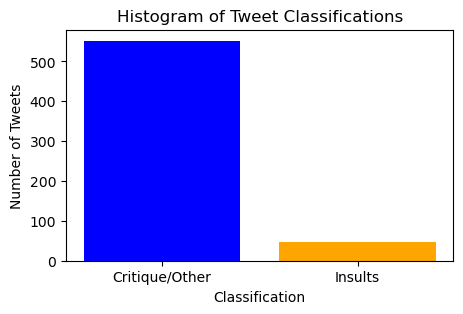

Critique/Other    552
Insults            48
Name: Classification, dtype: int64


In [27]:
import matplotlib.pyplot as plt

# Get counts
classification_counts = df1['Classification'].value_counts()

# Create histogram
plt.figure(figsize=(5, 3))
plt.bar(classification_counts.index, classification_counts.values, color=['blue', 'orange'])
plt.xlabel('Classification')
plt.ylabel('Number of Tweets')
plt.title('Histogram of Tweet Classifications')
plt.show()
print(classification_counts)

In [28]:
import pandas as pd

# Set max rows and columns
# Set max column width
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

df_insult = df1[df1['Classification'] == 'Insults']
df_critique = df1[df1['Classification'] == 'Critique/Other']
df_insult[['Tweet', 'Classification', 'Adjusted SentiWordScore', 'Subjects','Complements',"Dependency Children",
           'Aux/pronouns dependence','Has 1st Person', 'Has 2nd Person', 'Has 3rd Person', 'Named Entities', 'Has Discourse Marker', 
           'Has Question Mark', 'Has Third Person Verb', 'Adjectives']].sample(20)

,Tweet,Classification,Adjusted SentiWordScore,Subjects,Complements,Dependency Children,Aux/pronouns dependence,Has 1st Person,Has 2nd Person,Has 3rd Person,Named Entities,Has Discourse Marker,Has Question Mark,Has Third Person Verb,Adjectives
597,"Frankly, you're no better than my idiot cousin (not one of the cops) who tries to tell me my muslim coworkers and friends are secretly evil terrorists only here to kill us all and force sharia law on us all. The prejudice in this world is disgusting. All of you.",Insults,-0.318767,"[(you, [2]), (who, []), (prejudice, [])]","['re, better, friends, are, force, is, disgusting, All]","[[Frankly, ,, you, better, are, .], [], [secretly, terrorists, here, kill], [law, on], [prejudice, disgusting, .], [of, .]]","[[Frankly, ,, you, better, are, .], [secretly, terrorists, here, kill], [prejudice, disgusting, .]]",False,True,False,"[(muslim, NORP)]",False,False,False,"[better, muslim, evil, sharia, disgusting]"
504,_caldera you are an idiot. Your piece on face coveries by Muslim countries is unreal. It's like you know everything your saying is bullshit made up just to respond to people who think face shields are dumb. Any face covering should lower the numbers. Journalism is dead.,Insults,-0.236813,"[(you, [2]), (piece, []), (It, [3]), (you, [2]), (everything, []), (saying, []), (who, []), (shields, []), (face, []), (covering, []), (Journalism, [])]","[are, is, unreal, 's, dumb, lower, is, dead]","[[_, you, idiot, .], [piece, unreal, .], [It, like, know, made, .], [everything, saying, bullshit], [up, respond], [shields, dumb], [covering, should, numbers, .], [Journalism, dead, .]]","[[_, you, idiot, .], [piece, unreal, .], [It, like, know, made, .], [everything, saying, bullshit], [shields, dumb], [], [Journalism, dead, .]]",False,True,True,"[(Muslim, NORP)]",True,False,False,"[Muslim, unreal, dumb, dead]"
490,"Bloody hell I haven't been a size 4 since I was 15, uni what have you done to me",Insults,-0.340400,"[(I, [1]), (I, [1]), (you, [2])]",[been],"[[hell, I, have, n't, size, was, ,, uni, done], [what, have, you, to]]","[[], [hell, I, have, n't, size, was, ,, uni, done], [since, I, 15], []]",True,True,False,"[(4, CARDINAL), (15, DATE)]",False,False,False,[Bloody]
319,Cyber bullying: Out you go! | Malay Mail Online,Insults,-0.299700,"[(you, [2])]","[go, Online]","[[bullying, Out, you, !], [|, Mail]]","[[], [], [Malay], [|, Mail]]",False,True,False,"[(Malay Mail Online, PERSON)]",False,False,False,[]
102,you're all a bunch of dumb motherfuckers. Put a nigger dick in your mouth and shut the fuck up.,Insults,-0.350967,"[(you, [2])]","['re, Put, shut]","[[you, bunch, .], [dick, in, and, shut, .], [fuck, up]]","[[you, bunch, .]]",False,True,False,[],False,False,False,"[dumb, nigger]"
126,: HAHAHAHA FUCK YOU DUMB ASS NIGGER. YOUR THE REASON US WHITES HATE BLACK PEOPLE,Insults,-0.881400,"[(YOU, [2])]","[DUMB, REASON]","[[FUCK, YOU, NIGGER, .], [YOUR, THE, HATE]]","[[HAHAHAHA], [], [], [WHITES, PEOPLE]]",False,True,False,"[(US, GPE)]",False,False,False,[]
298,"all my bitches bad, you'll never see me around ugly females Ã°ÂÂÂ",Insults,-0.542300,"[(you, [2])]",[see],"[[bad, ,, you, 'll, never, me, around, Ã, °, ÂÂÂ]]","[[], []]",False,True,False,"[(ÂÂÂ, CARDINAL)]",False,False,False,"[bad, ugly]"
154,___ you dumb fuck. I'm saying that's what I am. That's why people call me sand nigger,Insults,-0.165600,"[(you, [2]), (I, [1]), (that, []), (I, [1]), (That, []), (people, [])]","[_, fuck, saying, 's]","[[_, _], [dumb, .], [I, 'm, 's, .], [that, am], [what, I], [That, call], [why, people, me, sand, nigger]]","[[], [that, am], [what, I], [That, call]]",True,True,False,[],True,False,False,[]
128,Fuck you uncle drew you don't follow anyone who retweets you dumb ugly fucken nigger,Insults,-0.324300,"[(uncle, []), (you, [2]), (who, [])]",[drew],"[[uncle, follow, nigger], [you, do, n't, anyone]]",[[]],False,True,False,[],False,False,False,[fucken]
563,Why do nearly half of all Muslims want to kill people

# Feature explanation 

In [ ]:
# Initialize lists to store data

# Create a VADER sentiment analyzer object
analyzer = SentimentIntensityAnalyzer()
data = []

for tweet in df['clean_data']:
    # Analyze the tweet
    doc = nlp(tweet)

    # Extract adjectives, nouns, subjects and complements/conjunctions/root
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    nouns = [token.text for token in doc if token.pos_ == "NOUN"]
    subjects = [(token.text, token.morph.get('Person')) for token in doc if token.dep_ == "nsubj"]
    complements = [token.text for token in doc if token.dep_ in ("acomp", "conj", "ROOT")]

    # Extract children of ccomp or conj
    ccomp_conj_children = []
    ccomp_conj_sentiments = []
    for token in doc:
        if token.dep_ in ("ccomp", "conj", 'ROOT'):
            children = [child.text for child in token.children]
            ccomp_conj_children.append(children)
            # Compute sentiment scores for each child and append to list
            ccomp_conj_sentiments.extend([analyzer.polarity_scores(child)["compound"] for child in children])

    # Compute sum of sentiment scores for ccomp or conj children
    sum_ccomp_conj_sentiment = sum(ccomp_conj_sentiments)

    # Extract named entities and their types
    named_entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Extract synonyms
    synonyms = []
    for token in doc:
        if token.pos_ in ("ADJ", "NOUN", 'ccomp'):
            for syn in wordnet.synsets(token.text):
                for lemma in syn.lemmas():
                    synonyms.append(lemma.name())

    # Create a polarity score
    sentiment_score = analyzer.polarity_scores(tweet)["compound"]
    synonyms_sentiment_score = analyzer.polarity_scores(" ".join(synonyms))["compound"]

    # Append data to list
    data.append({
        "Tweet": tweet,
        "Adjectives": adjectives,
        "Nouns": nouns,
        "Subjects": subjects,
        "Complements": complements,
        "CCOMP or CONJ Children": ccomp_conj_children,
        "CCOMP or CONJ Children Sum Sentiment": sum_ccomp_conj_sentiment,
        "Named Entities": named_entities,
       # "Synonyms": synonyms,
        "Sentiment Score": sentiment_score,
        "Synonyms Sentiment Score": synonyms_sentiment_score
    })

# Create DataFrame
df = pd.DataFrame(data)

In [446]:
test = "HOE you mad? damn right our PRESI§DENT IS BLACK ,tf you gone do bouh it? he smartn than romney ass : FUCK OBAMA, dumb ass nigger"
test ="I believe Russians are beautiful and Justin Trudeau is an angel, I love him"
test = 'Bell, based in Los Angeles, makes and distributes electronic, computer and building products.'
test = "That's PRESIDENT OBAMA to you tayyoung_: FUCK OBAMA, dumb ass nigger"
test = 'The God of Abraham works this way: dirt done is visited upon perpetrators. Your face is in headlines news across Europe for lowlife abusive language. Nothing to do representing Christian decency of Floridians, just making America look like an immature school yard of bullies.'
test =  "She criticized his work because she believed it lacked attention to detail."
instance1 = nlp(test)
    # for token in doc_text:
    #     print(token.text," : ",token.dep_, '|', token.head)
for token in instance1:
    print(token.text, token.dep_, token.head.text, token.head.pos_,
        [child for child in token.children])

token.children

She nsubj criticized VERB []
criticized ROOT criticized VERB [She, work, believed, .]
his poss work NOUN []
work dobj criticized VERB [his]
because mark believed VERB []
she nsubj believed VERB []
believed advcl criticized VERB [because, she, lacked]
it nsubj lacked VERB []
lacked ccomp believed VERB [it, attention, to]
attention dobj lacked VERB []
to prep lacked VERB [detail]
detail pobj to ADP []
. punct criticized VERB []


In [449]:
test = "That's PRESIDENT OBAMA to you tayyoung_: FUCK OBAMA, dumb ass nigger"
test = 'The God of Abraham works this way: dirt done is visited upon perpetrators. Your face is in headlines news across Europe for lowlife abusive language. Nothing to do representing Christian decency of Floridians, just making America look like an immature school yard of bullies.'
test = 'You idiot, Western slavery was started by the Muslims in Africa! They were sold to the Arabs by their “own” tribal chieftains!'
test = "HOE you mad? damn right our PRESI§DENT IS BLACK ,tf you gone do bouh it? he smartn than romney ass : FUCK OBAMA, dumb ass nigger"
test = 'Bell, based in Los Angeles, makes and distributes electronic, computer and building products.'
test =  "She criticized his work because she believed it lacked attention to detail."
test ="I believe Russians are beautiful and Justin Trudeau is an angel, I love him"
instance = nlp(test)
#This part of the library is imported for graphic visualization only.
from spacy import displacy

#For our doc object, we display the dependency graph, which allows us to better understand/analyze these relationships manually
displacy.render(instance, style="dep")

In [448]:
# Test the CCOMP function 
test = "That's PRESIDENT OBAMA to you tayyoung_: FUCK OBAMA, dumb ass nigger"
test = 'Bell, based in Los Angeles, makes and distributes electronic, computer and building products.'
test = "She does not look very beautiful"
test = 'You idiot, Western slavery was started by the Muslims in Africa! They were sold to the Arabs by their “own” tribal chieftains,	Insults'
test ="I believe Russians are beautiful and Justin Trudeau is an angel, I love him"

test 
doc = nlp(test)
# Extract adjectives, nouns, subjects and complements/conjunctions/root
adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
nouns = [token.text for token in doc if token.pos_ == "NOUN"]
subjects = [(token.text, token.morph.get('Person')) for token in doc if token.dep_ == "nsubj"]
complements = [token.text for token in doc if token.dep_ in ("ccomp", "conj", "ROOT")]

# Extract children of ccomp or conj
ccomp_conj_children = []
ccomp_conj_sentiments = []
AUX_child = []
text = []
textToken = []
for token in doc:
    if token.dep_ in ('ROOT', 'ccomp', 'conj'): # "ccomp", "obj", 'ROOT''AUX'
        children = [child.text for child in token.children]
        #children = token.text
        ccomp_conj_children.append(children)
        # Compute sentiment scores for each child and append to list
        #ccomp_conj_sentiments.extend([analyzer.polarity_scores(child)["compound"] for child in children])
    if token.pos_ in ("AUX", 'PROPN'): # "ccomp", "obj", 'ROOT''AUX'
            child = [child.text for child in token.children]
            AUX_child.append(child)
    if token.pos_ in ("ADJ"): # "ccomp", "obj", 'ROOT''AUX'
        text_1 = token.text
        #children = token.text
        text.append(text_1)
    if token.dep_ in ("acomp", 'advmod', 'amod',"appos", "coordination"): 
        text = token.text
        textToken.append(text)
print(ccomp_conj_children)
print(AUX_child)
print(text)
complements
textToken

[['I', 'are'], ['Russians', 'beautiful', 'and', 'is'], ['Trudeau', 'angel'], ['believe', ',', 'I', 'him']]
[[], ['Russians', 'beautiful', 'and', 'is'], [], ['Justin'], ['Trudeau', 'angel']]
beautiful


['beautiful']

## Exploration 